In this notebook: for **each modality** using simple **Linear Regression** and testing multiple fusion models.

Mounting drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.stats import pearsonr
import statsmodels.api as sm

In [ ]:
full_video_directory = r"/content/drive/MyDrive/Data-Multimotion/Features-NEW/Full"
intervals_directory = r"/content/drive/MyDrive/Data-Multimotion/Features-NEW/Intervals"
ground_truth_directory = r"/content/drive/MyDrive/Data-Multimotion/Ground truth"
results_directory = r"/content/drive/MyDrive/Data-Multimotion/Results"

# Data

In [ ]:
# List of videos used
videos = [
     "HN_1",
     "HN_2_H",
     "HN_4",
     "HN_5",
     "HN_6",
     "LP_3",
     "LP_4",
     "LP_6",
     "LN_1",
     "LN_2",
     "LN_3",
     "LN_4",
     "LN_5",
     "LN_6",
     "LN_7_N",
     "LN_9",
     "HP_1_L",
     "HP_2",
     "HP_3_L",
     "HP_4",
     "HP_6",
     "HP_7_H",
     "HN_3_H",
     "HN_9",
     "HN_7",
     "LP_1",
     "LP_2",
     "LP_5",
    "LP_7",
     "LP_9",
    "HP_5",
     "HP_9",
     "HN_2_L",
     "HN_3_L",
     "HP_1_H",
    "HP_3_H",
     "HP_7_L",
     "LN_7_P"]

In [ ]:
# FER Intervals - loading the csv
df_fer = pd.read_csv(os.path.join(intervals_directory, "FER_features.csv"))

I have to remove participants who don't have FER at all (this is because if they did not have FER in the raw files, I would just put NANs for all videos when doing feature extraction).

In [ ]:
# Columns to exclude from NaN check
exclude_cols = ['participant', 'video']

# Feature columns to check for NaNs
feature_cols = [col for col in df_fer.columns if col not in exclude_cols]

# Group by participant and check if all their feature values are NaN
participants_to_remove = df_fer.groupby('participant')[feature_cols].apply(
    lambda x: x.isna().all(axis=1).all()
)

# Filtering participant IDs to remove
participants_to_remove = participants_to_remove[participants_to_remove].index.tolist()

# Remove those participants from the DataFrame
df_fer_cleaned = df_fer[~df_fer['participant'].isin(participants_to_remove)]

# Showing results
print(f"Number of participants removed: {len(participants_to_remove)}")
print("Participants removed:")
print(participants_to_remove)

# Reassigning the df
df_fer = df_fer_cleaned

Number of participants removed: 5
Participants removed:
['7yqP3', 'GHft8', 'WYuvqk', 'XPI3pA', 'h2yD5h']


In [ ]:
# PUPIL Intervals - Loading the csv
df_pupil = pd.read_csv(os.path.join(intervals_directory, "Pupil_size.csv"))

In [ ]:
# Group by participant and check if all Pupil_size values are NaN
participants_to_remove = df_pupil.groupby('participant')["Pupil_size"].apply(
    lambda x: x.isna().all()
)

# Get list of participants to remove
participants_to_remove = participants_to_remove[participants_to_remove].index.tolist()

# Remove those participants from the DataFrame
df_pupil_cleaned = df_pupil[~df_pupil['participant'].isin(participants_to_remove)]

# Show results
print(f"Number of participants removed: {len(participants_to_remove)}")
print("Participants removed:")
print(participants_to_remove)

df_pupil = df_pupil_cleaned

Number of participants removed: 1
Participants removed:
['Fyt7d']


In [ ]:
# GSR Full videos - Loading the csv
df_gsr_full = pd.read_csv(os.path.join(full_video_directory, "gsr_features.csv"))
df_gsr_full.rename(columns={"ParticipantID": "participant", "StimulusName": "video"}, inplace=True)


In [ ]:
# GSR Intervals - Loading the csv
df_gsr_intervals = pd.read_csv(os.path.join(intervals_directory, "gsr_features_intervals.csv"))
df_gsr_intervals.rename(columns={"ParticipantID": "participant", "StimulusName": "video"}, inplace=True)


Some participants that were not removed do not have all 38 videos so I am filtering to keep only those that have same umber of videos for all features.

In [ ]:
participant_col = 'participant'
video_col = 'video'

def participants_with_all_videos(df):
    """ Filter participants that do not have all videos in the dataset. """
    # Keep only rows with videos
    df_filtered = df[df[video_col].isin(videos)]

    # Count number of unique videos per participant
    counts = df_filtered.groupby(participant_col)[video_col].nunique()

    # Participants who have all videos (equal to the length of videos list)
    return counts[counts == len(videos)].index

# Find participants with all videos in each dataframe
participants_fer = participants_with_all_videos(df_fer)
participants_pupil = participants_with_all_videos(df_pupil)
participants_gsr = participants_with_all_videos(df_gsr_full)

# Find intersection of participants across all three dataframes
common_participants = set(participants_fer) & set(participants_pupil) & set(participants_gsr)

# Filtering each dataframe to keep only common participants and videos
df_fer_filtered = df_fer[(df_fer[participant_col].isin(common_participants)) & (df_fer[video_col].isin(videos))]
df_pupil_filtered = df_pupil[(df_pupil[participant_col].isin(common_participants)) & (df_pupil[video_col].isin(videos))]
df_gsr_filtered = df_gsr_full[(df_gsr_full[participant_col].isin(common_participants)) & (df_gsr_full[video_col].isin(videos))]

# Merge the dataframes on participant_id and video with inner joins
merged_1 = df_fer_filtered.merge(df_pupil_filtered, on=[participant_col, video_col], how='inner')
df = merged_1.merge(df_gsr_filtered, on=[participant_col, video_col], how='inner')

# Store original feature sets (excluding participant and video columns)
fer_features = [col for col in df_fer_filtered.columns if col not in [participant_col, video_col]]
pupil_features = [col for col in df_pupil_filtered.columns if col not in [participant_col, video_col]]
gsr_features = [col for col in df_gsr_filtered.columns if col not in [participant_col, video_col]]

In [ ]:
df.head()

,participant,video,FER_Mean_Valence,FER_Mean_Arousal,FER_Std_Valence,FER_Std_Arousal,FER_Kurtosis_Valence,FER_Kurtosis_Arousal,FER_Max_Valence,FER_Max_Arousal,...,skewMFCC_3,skewMFCC_4,skewMFCC_5,skewMFCC_6,skewMFCC_7,skewMFCC_8,skewMFCC_9,skewMFCC_10,skewMFCC_11,skewMFCC_12
0,F5tXL,LP_6,0.000952,-0.000626,0.000541,0.000835,4.019652,19.588990,0.003014,-0.000161,...,0.695944,0.764121,0.790389,0.795862,0.789622,0.777750,0.762914,0.747217,0.731438,0.716298
1,F5tXL,LN_1,0.001459,-0.002051,0.001544,0.003596,9.711684,10.133371,0.010409,-0.000118,...,0.362375,0.005245,0.029354,-0.062371,-0.070456,-0.111330,-0.124169,-0.149200,-0.161704,-0.179115
2,F5tXL,LP_5,0.192954,0.566484,0.036930,0.212372,3.386188,2.554266,0.346534,0.773791,...,0.670047,0.719782,0.756339,0.783775,0.803970,0.819082,0.830339,0.838862,0.845317,0.850206
3,F5tXL,HP_3_L,0.107633,0.322872,0.129906,0.394061,-1.289344,-1.739915,0.409336,0.906473,...,0.809794,0.681817,0.595605,0.523772,0.467364,0.421189,0.385459,0.356580,0.334364,0.316736
4,F5tXL,HP_3_H,0.256877,0.735755,0.049578,0.130069,-1.112521,-1.058543,0.356418,0.881853,...,0.949351,0.968432,1.024748,1.070044,1.112122,1.144947,1.173121,1.195324,1.214095,1.229331


In [ ]:
# Count unique participants
num_participants = df['participant'].nunique()
print(f"Number of unique participants: {num_participants}")

# Count number of videos per participant
videos_per_participant = df.groupby('participant')['video'].nunique()

# Display summary statistics
print("\nVideos per participant (summary):")
print(videos_per_participant.describe())

# Full list of how many videos each participant has
print(videos_per_participant.sort_values())

Number of unique participants: 36

Videos per participant (summary):
count    36.0
mean     38.0
std       0.0
min      38.0
25%      38.0
50%      38.0
75%      38.0
max      38.0
Name: video, dtype: float64
participant
4FoNM      38
5KB3V      38
6GSd4      38
8vDRG      38
9FGka      38
CoQmx      38
Cr1sTi     38
D9Hh9      38
EJOiBs     38
EXAMPLE    38
F5tXL      38
F8mDn      38
Fjil72     38
G4Egk      38
G5XzoP     38
Gax8       38
Gftw5      38
Hx7dO      38
KWgkc      38
KoG5ii     38
LR96S      38
M4t7k      38
NMy2s      38
O1pGR      38
PPjCX      38
Pi9803     38
VckNZ      38
WQzBV      38
XhsN0o     38
gf5X       38
gjGzb      38
hMHEK1     38
tMGNS      38
urJvc      38
wohkw      38
yb3T2      38
Name: video, dtype: int64


### Loading ground truth

In [ ]:
# Load full ground truth (this is done only once)
gt_full_set = pd.read_csv(os.path.join(ground_truth_directory, "individual_ground_truth.csv"))

# Renaming so it is the same as FER and Pupil
gt_full_set.rename(columns={"Participant": "participant", "Stimulus_Name": "video"}, inplace=True)

In [ ]:
def load_ground_truth_exclude(participant_id):
    """ Function to load ground truth file for excluding one participant for Leave One Participant Out. """

    # Load the ground truth file excluding this participant
    file_path = os.path.join(ground_truth_directory + f"/Leave-one-out/individual_ground_truth_no_{participant_id}.csv")

    gt_df = pd.read_csv(file_path)
    return gt_df

# Arousal

In [ ]:
# Check for NaN values in thes numeric feature columns
print(df.isnull().sum())

participant         0
video               0
FER_Mean_Valence    0
FER_Mean_Arousal    0
FER_Std_Valence     0
                   ..
skewMFCC_8          0
skewMFCC_9          0
skewMFCC_10         0
skewMFCC_11         0
skewMFCC_12         0
Length: 153, dtype: int64


In [ ]:
df['FER_Min_Valence'] = 0

### Each model performance

First, I want to see how each model performs:

In [ ]:
participants = df['participant'].unique()

# Lists to append the metrics
fer_nrmse, fer_r2, fer_corr, fer_p = [], [], [], []
pupil_nrmse, pupil_r2, pupil_corr, pupil_p = [], [], [], []
gsr_nrmse, gsr_r2, gsr_corr, gsr_p = [], [], [], []

# Final predictions lists
true_all, pred_fer_all, pred_pupil_all, pred_gsr_all = [], [], [], []

for test_pid in participants:
    # Get the test participant data
    test_data = df[df['participant'] == test_pid].copy()

    # Use full GT for test participant
    test_gt = gt_full_set[gt_full_set['participant'] == test_pid]
    test_data = test_data.merge(test_gt[['participant', 'video', 'Arousal']], on=['participant', 'video'], how='inner')

    train_data = df[df['participant'] != test_pid].copy()

    # Loading the GT excluding the test participant
    pid_gt = load_ground_truth_exclude(test_pid)
    pid_gt.rename(columns={"Participant": "participant", "Stimulus_Name": "video"}, inplace=True)

    # Merging the train data with GT
    train_data = train_data.merge(pid_gt[['participant', 'video', 'Arousal']], on=['participant', 'video'], how='inner')

    non_feature_cols = ['participant', 'video']
    feature_cols = df_fer.drop(columns=non_feature_cols).select_dtypes(include=[np.number]).columns.tolist()

    # FER
    X_fer = train_data[fer_features]
    y_fer = train_data['Arousal']
    X_fer_test = test_data[fer_features]
    y_fer_test = test_data['Arousal']

    # Train FER model
    model_fer = LinearRegression()
    model_fer.fit(X_fer, y_fer)
    test_preds_fer = model_fer.predict(X_fer_test)

    # Pupil
    X_pupil = train_data[pupil_features]
    y_pupil = train_data['Arousal']
    X_pupil_test = test_data[pupil_features]
    y_pupil_test = test_data['Arousal']

    # Train Pupil model
    model_pupil = LinearRegression()
    model_pupil.fit(X_pupil, y_pupil)
    test_preds_pupil = model_pupil.predict(X_pupil_test)

    # GSR
    X_gsr = train_data[gsr_features]
    y_gsr = train_data['Arousal']
    X_gsr_test = test_data[gsr_features]
    y_gsr_test = test_data['Arousal']

    # Train GSR model
    model_gsr = LinearRegression()
    model_gsr.fit(X_gsr, y_gsr)
    test_preds_gsr = model_gsr.predict(X_gsr_test)

     # Final predictions and true values
    true_all.extend(y_fer_test.values)
    pred_fer_all.extend(test_preds_fer)
    pred_pupil_all.extend(test_preds_pupil)
    pred_gsr_all.extend(test_preds_gsr)

    # Metrics for FER
    range_fer = y_fer_test.max() - y_fer_test.min()
    fer_nrmse.append(root_mean_squared_error(y_fer_test, test_preds_fer) / range_fer)
    fer_r2.append(r2_score(y_fer_test, test_preds_fer))
    corr_fer, pval_fer = pearsonr(y_fer_test, test_preds_fer)
    fer_corr.append(corr_fer)
    fer_p.append(pval_fer)

    # Metrics for Pupil
    range_pupil = y_pupil_test.max() - y_pupil_test.min()
    pupil_nrmse.append(root_mean_squared_error(y_pupil_test, test_preds_pupil) / range_pupil)
    pupil_r2.append(r2_score(y_pupil_test, test_preds_pupil))
    corr_pupil, pval_pupil = pearsonr(y_pupil_test, test_preds_pupil)
    pupil_corr.append(corr_pupil)
    pupil_p.append(pval_pupil)

    # Metrics for GSR
    range_gsr = y_gsr_test.max() - y_gsr_test.min()
    gsr_nrmse.append(root_mean_squared_error(y_gsr_test, test_preds_gsr) / range_gsr)
    gsr_r2.append(r2_score(y_gsr_test, test_preds_gsr))
    corr_gsr, pval_gsr = pearsonr(y_gsr_test, test_preds_gsr)
    gsr_corr.append(corr_gsr)
    gsr_p.append(pval_gsr)

# Finally combined evaluation for all participants
true_all = np.array(true_all)
pred_fer_all = np.array(pred_fer_all)
pred_pupil_all = np.array(pred_pupil_all)
pred_gsr_all = np.array(pred_gsr_all)

def compute_final_metrics(y_true, y_pred):
    """ Function to compute final metrics across all participants. """
    nrmse = root_mean_squared_error(y_true, y_pred) / (y_true.max() - y_true.min())
    r2 = r2_score(y_true, y_pred)
    corr, pval = pearsonr(y_true, y_pred)
    return nrmse, r2, corr, pval

fer_final = compute_final_metrics(true_all, pred_fer_all)
pupil_final = compute_final_metrics(true_all, pred_pupil_all)
gsr_final = compute_final_metrics(true_all, pred_gsr_all)

print("\n=== FINAL METRICS ===")
print(f"FER   -> NRMSE: {fer_final[0]:.4f}, R²: {fer_final[1]:.4f}, Corr: {fer_final[2]:.4f}, p: {fer_final[3]:.4g}")
print(f"Pupil -> NRMSE: {pupil_final[0]:.4f}, R²: {pupil_final[1]:.4f}, Corr: {pupil_final[2]:.4f}, p: {pupil_final[3]:.4g}")
print(f"GSR   -> NRMSE: {gsr_final[0]:.4f}, R²: {gsr_final[1]:.4f}, Corr: {gsr_final[2]:.4f}, p: {gsr_final[3]:.4g}")


=== FINAL METRICS ===
FER   -> NRMSE: 0.2507, R²: 0.0008, Corr: 0.1036, p: 0.0001228
Pupil -> NRMSE: 0.2304, R²: 0.1563, Corr: 0.3954, p: 2.08e-52
GSR   -> NRMSE: 0.5279, R²: -3.4283, Corr: 0.1956, p: 2.87e-13


In [ ]:
# ---- PER-PARTICIPANT METRICS ---- #
metrics_df = pd.DataFrame({
    "participant": participants,
    "fer_nrmse": fer_nrmse,
    "fer_r2": fer_r2,
    "fer_corr": fer_corr,
    "fer_p": fer_p,

    "pupil_nrmse": pupil_nrmse,
    "pupil_r2": pupil_r2,
    "pupil_corr": pupil_corr,
    "pupil_p": pupil_p,

    "gsr_nrmse": gsr_nrmse,
    "gsr_r2": gsr_r2,
    "gsr_corr": gsr_corr,
    "gsr_p": gsr_p,
})

# Save to CSV
metrics_df.to_csv(os.path.join(results_directory, "LOPO Regression/arousal_each_model_per_participant_metrics.csv"), index=False)


# ---- FINAL SUMMARY ---- #
final_df = pd.DataFrame({
    "modality": ["FER", "Pupil", "GSR"],
    "nrmse": [fer_final[0], pupil_final[0], gsr_final[0]],
    "r2":    [fer_final[1], pupil_final[1], gsr_final[1]],
    "corr":  [fer_final[2], pupil_final[2], gsr_final[2]],
    "p":     [fer_final[3], pupil_final[3], gsr_final[3]]
})

final_df.to_csv(os.path.join(results_directory, "LOPO Regression/arousal_each_model_final_summary_metrics.csv"), index=False)

print("Saved CSV results to `Results/` folder.")

Saved CSV results to `Results/` folder.


### Fusion model

In [ ]:
def get_train_test_data(df, gt_full_set, test_pid):
    """Splitting the data into train and test and merge correctly with ground truth."""
    test_data = df[df['participant'] == test_pid].copy()
    test_gt = gt_full_set[gt_full_set['participant'] == test_pid]
    test_data = test_data.merge(test_gt[['participant', 'video', 'Arousal']], on=['participant', 'video'], how='inner')

    train_data = df[df['participant'] != test_pid].copy()

    # Individual GT without participant test_pid
    pid_gt = load_ground_truth_exclude(test_pid)
    pid_gt.rename(columns={"Participant": "participant", "Stimulus_Name": "video"}, inplace=True)
    train_data = train_data.merge(pid_gt[['participant', 'video', 'Arousal']], on=['participant', 'video'], how='inner')

    return train_data, test_data


def train_modality_model(train_data, test_data, features):
    """ Train a Linear Regression model on specific modality features. """
    X_train = train_data[features]
    y_train = train_data['Arousal']

    X_test = test_data[features]
    y_test = test_data['Arousal']

    model = LinearRegression()
    model.fit(X_train, y_train)
    return model, model.predict(X_train), model.predict(X_test), y_test.values


def evaluate_fusion_model(y_true, y_pred):
    """ Calculate evaluation metrics. """
    rmse = root_mean_squared_error(y_true, y_pred)
    nrmse = rmse / (y_true.max() - y_true.min())
    r2 = r2_score(y_true, y_pred)
    corr, p_val = pearsonr(y_true, y_pred)
    return {'NRMSE': nrmse, 'R2': r2, 'corr': corr, 'p': p_val}

def get_level1_train_data(train_data, fer_features, pupil_features, gsr_features, val_ratio=0.3):
    """ Create validation set predictions for training the fusion model (level-1). """
    modality_train, modality_val = train_test_split(train_data, test_size=val_ratio, random_state=42)

    # Train each modality model on modality_train
    model_fer, _, val_fer, _ = train_modality_model(modality_train, modality_val, fer_features)
    model_pupil, _, val_pupil, _ = train_modality_model(modality_train, modality_val, pupil_features)
    model_gsr, _, val_gsr, y_val = train_modality_model(modality_train, modality_val, gsr_features)

    # Stack predictions to create the fusion training input
    fusion_X_train = np.vstack([val_fer, val_pupil, val_gsr]).T
    fusion_y_train = y_val

    return fusion_X_train, fusion_y_train, model_fer, model_pupil, model_gsr


def run_participant_loop(df, gt_full_set, fusion_model_cls, fusion_model_kwargs={}):
    """ Loop through each participant, split data, train models and evaluate. """
    participants = df['participant'].unique()
    participant_results = []
    fusion_weights = {}
    all_fusion_preds, all_true_values, all_test_participants = [], [], []

    for test_pid in participants:
        train_data, test_data = get_train_test_data(df, gt_full_set, test_pid)

        # Get level-1 training data without leakage
        fusion_X_train, fusion_y_train, model_fer, model_pupil, model_gsr = get_level1_train_data(
            train_data, fer_features, pupil_features, gsr_features
        )

        # Predict on test set using the trained modality models
        _, _, test_fer, y_test = train_modality_model(train_data, test_data, fer_features)
        _, _, test_pupil, _ = train_modality_model(train_data, test_data, pupil_features)
        _, _, test_gsr, _ = train_modality_model(train_data, test_data, gsr_features)

        fusion_X_test = np.vstack([test_fer, test_pupil, test_gsr]).T

        # Train and predict with the fusion model
        model_fusion = fusion_model_cls(**fusion_model_kwargs)
        model_fusion.fit(fusion_X_train, fusion_y_train)
        fusion_preds = model_fusion.predict(fusion_X_test)

        # Store weights if linear model
        if hasattr(model_fusion, 'coef_'):
            fusion_weights[test_pid] = model_fusion.coef_

        # Evaluate
        metrics = evaluate_fusion_model(y_test, fusion_preds)
        metrics['participant'] = test_pid
        participant_results.append(metrics)

        all_fusion_preds.extend(fusion_preds)
        all_true_values.extend(y_test)
        all_test_participants.extend([test_pid] * len(y_test))

    return participant_results, fusion_weights, all_fusion_preds, all_true_values, all_test_participants

In [ ]:
def evaluate_global_metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    corr, p_val = pearsonr(y_true, y_pred)
    return {
        'RMSE': rmse,
        'NRMSE': nrmse,
        'R2': r2,
        'corr': corr,
        'p': p_val
    }


def print_global_metrics(metrics, title="=== Arousal Model Overall Global Metrics ==="):
    print(f"\n{title}")
    print(f"Global NRMSE: {metrics['NRMSE']:.4f}")
    print(f"Global R²: {metrics['R2']:.4f}")
    print(f"Global corr: {metrics['corr']:.4f}, p = {metrics['p']:.4e}")


def print_fusion_weights_summary(fusion_weights):
    if fusion_weights:
        weights_df = pd.DataFrame(fusion_weights).T
        weights_df.columns = ['FER_weight', 'Pupil_weight', 'GSR_weight']
        print("\nAverage Fusion Weights across Participants:")
        print(weights_df.mean().round(4))


def print_per_participant_metrics(results_df):
    print("\n=== Arousal Model Per-Participant Fusion Metrics ===")
    print(results_df.round(4))
    summary = results_df[['NRMSE', 'R2', 'corr', 'p']].agg(['mean', 'std'])
    print("\n=== Summary Across Participants ===")
    print(summary.round(4))


def print_filtered_summary(results_df):
    filtered = results_df[
        (results_df['R2'] > -1.0) &
        (results_df['NRMSE'] < 1.5) &
        (results_df['corr'].abs() > 0.2)
    ]
    summary_filtered = filtered[['NRMSE', 'R2', 'corr', 'p']].agg(['mean', 'std'])
    print("\n=== Summary (Excluding Outliers) ===")
    print(summary_filtered.round(4))


def run_evaluation_pipeline(df, gt_full_set, model_cls, model_kwargs):
    """ Evaluate the LOPO results. """
    print(f"\n Arousal Model Running with Fusion Model: {model_cls.__name__}")
    participant_results, fusion_weights, all_preds, all_true, all_test_participants = run_participant_loop(
        df, gt_full_set, model_cls, model_kwargs
    )

    global_metrics = evaluate_global_metrics(all_true, all_preds)

    print_global_metrics(global_metrics)
    print_fusion_weights_summary(fusion_weights)

    results_df = pd.DataFrame(participant_results)
    print_per_participant_metrics(results_df)
    print_filtered_summary(results_df)

    return results_df, global_metrics

#### **Linear Regression**

---



In [ ]:
# ---- Run and Print Results -----
fusion_model_cls = LinearRegression
fusion_model_kwargs = {}

participant_results, fusion_weights, all_fusion_preds, all_true_values, all_test_participants = run_participant_loop(df, gt_full_set, fusion_model_cls, fusion_model_kwargs)

global_metrics = evaluate_global_metrics(all_true_values, all_fusion_preds)

print_global_metrics(global_metrics)
print_fusion_weights_summary(fusion_weights)


=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.3482
Global R²: -0.9270
Global corr: 0.2598, p = 1.5308e-22

Average Fusion Weights across Participants:
FER_weight      0.0860
Pupil_weight    0.9156
GSR_weight      0.4070
dtype: float64


In [ ]:
results_df = pd.DataFrame(participant_results)
print_per_participant_metrics(results_df)


=== Arousal Model Per-Participant Fusion Metrics ===
     NRMSE       R2    corr       p participant
0   0.2774   0.2853  0.5881  0.0001       F5tXL
1   0.2634   0.3559  0.6403  0.0000        Gax8
2   0.2911   0.2131  0.5153  0.0009       Hx7dO
3   0.2478   0.4300  0.6896  0.0000       wohkw
4   0.2535   0.4031  0.6573  0.0000       PPjCX
5   0.2474   0.4318  0.6718  0.0000       tMGNS
6   0.2450   0.4428  0.6710  0.0000       5KB3V
7   0.2847   0.2474  0.5554  0.0003      EJOiBs
8   0.2444   0.4454  0.6963  0.0000        gf5X
9   0.2470   0.4336  0.7067  0.0000       gjGzb
10  0.2581   0.3816  0.6393  0.0000       LR96S
11  0.2661   0.3426  0.6170  0.0000       CoQmx
12  0.2674   0.3363  0.6230  0.0000      G5XzoP
13  0.2352   0.4865  0.7023  0.0000      XhsN0o
14  0.3208   0.0442  0.5099  0.0011       9FGka
15  0.2842   0.2503  0.5036  0.0013      hMHEK1
16  0.2493   0.4231  0.6582  0.0000       4FoNM
17  0.2707   0.3196  0.6036  0.0001       8vDRG
18  0.2785   0.2800  0.6044  0.000

However, there are a few participants with concerning results that might be worth paying attention.

Most participants have:

*   NRMSE ≈ 0.2–0.3
*   R² between 0.2 and 0.5

But there are outliers:


*   Participants **D9Hh9** , **Cr1sTi**: This is essentially random/noisy prediction, have again negative or very low R² and relatively high NRMSE.





**Flag and Exclude Extreme Outliers for Summary Stats**



In [ ]:
print_filtered_summary(results_df)


=== Summary (Excluding Outliers) ===
       NRMSE      R2    corr       p
mean  0.2770  0.2809  0.5832  0.0020
std   0.0274  0.1480  0.0944  0.0064


**Investigate the Outliers**


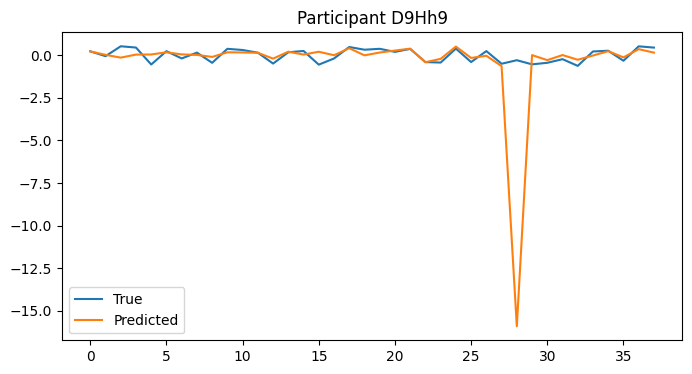

In [ ]:
import matplotlib.pyplot as plt

bad_pid = 'D9Hh9'
mask = np.array(all_test_participants) == bad_pid
plt.figure(figsize=(8, 4))
plt.plot(np.array(all_true_values)[mask], label='True')
plt.plot(np.array(all_fusion_preds)[mask], label='Predicted')
plt.title(f'Participant {bad_pid}')
plt.legend()
plt.show()

#### **Ridge regression**

---



In [ ]:
# Try Ridge
results_ridge, metrics_ridge = run_evaluation_pipeline(df, gt_full_set, Ridge, {'alpha': 1.0})


 Arousal Model Running with Fusion Model: Ridge

=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.3416
Global R²: -0.8542
Global corr: 0.2538, p = 1.5015e-21

Average Fusion Weights across Participants:
FER_weight      0.0668
Pupil_weight    0.8289
GSR_weight      0.3991
dtype: float64

=== Arousal Model Per-Participant Fusion Metrics ===
     NRMSE       R2    corr       p participant
0   0.2766   0.2896  0.5930  0.0001       F5tXL
1   0.2651   0.3475  0.6439  0.0000        Gax8
2   0.2906   0.2156  0.5144  0.0010       Hx7dO
3   0.2493   0.4229  0.6931  0.0000       wohkw
4   0.2551   0.3958  0.6611  0.0000       PPjCX
5   0.2451   0.4423  0.6774  0.0000       tMGNS
6   0.2458   0.4389  0.6712  0.0000       5KB3V
7   0.2807   0.2682  0.5593  0.0003      EJOiBs
8   0.2469   0.4338  0.7004  0.0000        gf5X
9   0.2504   0.4178  0.7079  0.0000       gjGzb
10  0.2573   0.3854  0.6410  0.0000       LR96S
11  0.2658   0.3440  0.6324  0.0000       CoQmx
12  0.2584   0.3800  0

#### **Random Forest Regression**

---



In [ ]:
# Try Random Forest
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, RandomForestRegressor, {'n_estimators': 100, 'random_state': 42})


 Arousal Model Running with Fusion Model: RandomForestRegressor

=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.1935
Global R²: 0.4050
Global corr: 0.6443, p = 2.7070e-161

=== Arousal Model Per-Participant Fusion Metrics ===
     NRMSE      R2    corr       p participant
0   0.2612  0.3665  0.6105  0.0000       F5tXL
1   0.2504  0.4178  0.6483  0.0000        Gax8
2   0.2362  0.4819  0.7045  0.0000       Hx7dO
3   0.2477  0.4304  0.6659  0.0000       wohkw
4   0.2092  0.5936  0.7758  0.0000       PPjCX
5   0.2310  0.5046  0.7416  0.0000       tMGNS
6   0.2355  0.4852  0.7501  0.0000       5KB3V
7   0.2557  0.3929  0.6484  0.0000      EJOiBs
8   0.2052  0.6092  0.7893  0.0000        gf5X
9   0.2683  0.3315  0.5958  0.0001       gjGzb
10  0.2756  0.2946  0.6136  0.0000       LR96S
11  0.2894  0.2226  0.5053  0.0012       CoQmx
12  0.2451  0.4422  0.6683  0.0000      G5XzoP
13  0.2516  0.4121  0.7680  0.0000      XhsN0o
14  0.3161  0.0722  0.6612  0.0000       9FGka
15  0.2

As expected, RandomForestRegressor did a better job because it can handle outliers and heterogenour patterns between participants.

#### **GradientBoostingRegressor**

---



In [ ]:
# Try Gradient Boosting Regressor
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, GradientBoostingRegressor,
 {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'random_state': 42})


 Arousal Model Running with Fusion Model: GradientBoostingRegressor

=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.1964
Global R²: 0.3868
Global corr: 0.6405, p = 7.8958e-159

=== Arousal Model Per-Participant Fusion Metrics ===
     NRMSE      R2    corr       p participant
0   0.2444  0.4452  0.6694  0.0000       F5tXL
1   0.2573  0.3852  0.6223  0.0000        Gax8
2   0.2576  0.3838  0.6305  0.0000       Hx7dO
3   0.2347  0.4884  0.7092  0.0000       wohkw
4   0.2195  0.5524  0.7476  0.0000       PPjCX
5   0.2206  0.5483  0.7675  0.0000       tMGNS
6   0.2554  0.3944  0.7121  0.0000       5KB3V
7   0.2525  0.4082  0.6789  0.0000      EJOiBs
8   0.2095  0.5924  0.7741  0.0000        gf5X
9   0.2846  0.2477  0.5731  0.0002       gjGzb
10  0.2822  0.2606  0.6301  0.0000       LR96S
11  0.2734  0.3060  0.5727  0.0002       CoQmx
12  0.2535  0.4033  0.6574  0.0000      G5XzoP
13  0.2600  0.3723  0.7753  0.0000      XhsN0o
14  0.3249  0.0199  0.6430  0.0000       9FGka
15 

#### **SVR Support Vector Regression**

---



In [ ]:
# Try SVR
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set,SVR, {'kernel':'rbf', 'C':1.0, 'epsilon':0.1})


 Arousal Model Running with Fusion Model: SVR

=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.1888
Global R²: 0.4335
Global corr: 0.6655, p = 1.0411e-175

=== Arousal Model Per-Participant Fusion Metrics ===
     NRMSE      R2    corr       p participant
0   0.2694  0.3260  0.5802  0.0001       F5tXL
1   0.2307  0.5059  0.7151  0.0000        Gax8
2   0.2776  0.2843  0.5948  0.0001       Hx7dO
3   0.2181  0.5583  0.7494  0.0000       wohkw
4   0.2285  0.5154  0.7190  0.0000       PPjCX
5   0.2465  0.4358  0.7327  0.0000       tMGNS
6   0.2028  0.6181  0.8095  0.0000       5KB3V
7   0.2478  0.4299  0.6907  0.0000      EJOiBs
8   0.1992  0.6315  0.7989  0.0000        gf5X
9   0.2420  0.4563  0.6792  0.0000       gjGzb
10  0.2728  0.3089  0.6693  0.0000       LR96S
11  0.2314  0.5026  0.7139  0.0000       CoQmx
12  0.2364  0.4811  0.6968  0.0000      G5XzoP
13  0.2075  0.6003  0.8138  0.0000      XhsN0o
14  0.2964  0.1843  0.6741  0.0000       9FGka
15  0.2597  0.3739  0.642

### Checking normalization

Code to check if it is better with or without using normalization.

In [ ]:
participants = df['participant'].unique()

results_file = results_directory + "/LOPO Regression/normalization_comparison.txt"

with open(results_file, 'a') as f:
  f.write("GSR LINEAR REGRESSION MODEL NORMALIZATION/COMPARISON - MIN MAX SCALER -1 and 1 \n\n")

# Lists to store all RMSEs for summary
rmse_raw_list = []
rmse_scaled_list = []

with open(results_file, 'a') as f:
  for test_pid in participants:
      # Get the test data
      test_data = df[df['participant'] == test_pid].copy()

      # Use full GT for test participant
      test_gt = gt_full_set[gt_full_set['participant'] == test_pid]
      test_data = test_data.merge(test_gt[['participant', 'video', 'Arousal']], on=['participant', 'video'], how='inner')

      train_data = df[df['participant'] != test_pid].copy()

      # Loading the GT excluding the test participant
      pid_gt = load_ground_truth_exclude(test_pid)
      pid_gt.rename(columns={"Participant": "participant", "Stimulus_Name": "video"}, inplace=True)

      # Merging the train data with GT
      train_data = train_data.merge(pid_gt[['participant', 'video', 'Arousal']], on=['participant', 'video'], how='inner')

      non_feature_cols = ['participant', 'video']
      feature_cols = df_fer.drop(columns=non_feature_cols).select_dtypes(include=[np.number]).columns.tolist()

      # CHANGE here which features
      X_train = train_data[gsr_features]
      y_train = train_data['Arousal']
      X_test = test_data[gsr_features]
      y_test = test_data['Arousal']

        # --- Without Normalization ---
      model_raw = LinearRegression()
      model_raw.fit(X_train, y_train)
      preds_raw = model_raw.predict(X_test)
      rmse_raw = root_mean_squared_error(y_test, preds_raw)

        # --- With Normalization ---
      scaler = MinMaxScaler(feature_range=(-1, 1))
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)

      model_scaled = LinearRegression()
      model_scaled.fit(X_train_scaled, y_train)
      preds_scaled = model_scaled.predict(X_test_scaled)
      rmse_scaled = root_mean_squared_error(y_test, preds_scaled)

         # Save for summary
      rmse_raw_list.append(rmse_raw)
      rmse_scaled_list.append(rmse_scaled)

        # Write results to file
      f.write(f"Participant: {test_pid}\n")
      f.write(f"  RMSE without normalization: {rmse_raw:.4f}\n")
      f.write(f"  RMSE with normalization:    {rmse_scaled:.4f}\n")
      f.write("-" * 40 + "\n")

  # Show summary
  avg_rmse_raw = np.mean(rmse_raw_list)
  avg_rmse_scaled = np.mean(rmse_scaled_list)

  f.write("SUMMARY:\n")
  f.write(f"Average RMSE without normalization: {avg_rmse_raw:.4f}\n")
  f.write(f"Average RMSE with normalization:    {avg_rmse_scaled:.4f}\n")
  f.write("=" * 40 + "\n")

print(f"Text results saved to {results_file}")





Text results saved to /content/drive/MyDrive/Data-Multimotion/Results/LOPO Regression/normalization_comparison.txt


Check https://drive.google.com/drive/u/0/folders/19eYcVkfGXxd0rdg8hX7dW9Z8oAtk4twC

So basically, for FER/Pupil with our without normalization the results (RMSE) is the same but for GSR when using normalization results are not so good => I will not use normalization.

# Valence

In [ ]:
df['FER_Min_Valence'] = 0

### Each model performance

In [ ]:
participants = df['participant'].unique()

# Lists to save the metrics
fer_nrmse, fer_r2, fer_corr, fer_p = [], [], [], []
pupil_nrmse, pupil_r2, pupil_corr, pupil_p = [], [], [], []
gsr_nrmse, gsr_r2, gsr_corr, gsr_p = [], [], [], []

# Final predictions lists
true_all, pred_fer_all, pred_pupil_all, pred_gsr_all = [], [], [], []


for test_pid in participants:
    # Get test data for participant
    test_data = df[df['participant'] == test_pid].copy()

    # Use full GT for test participant
    test_gt = gt_full_set[gt_full_set['participant'] == test_pid]
    test_data = test_data.merge(test_gt[['participant', 'video', 'Valence']], on=['participant', 'video'], how='inner')

    train_data = df[df['participant'] != test_pid].copy()

    # Loading the GT excluding the test participant
    pid_gt = load_ground_truth_exclude(test_pid)
    pid_gt.rename(columns={"Participant": "participant", "Stimulus_Name": "video"}, inplace=True)

    # Merging the train data with GT
    train_data = train_data.merge(pid_gt[['participant', 'video', 'Valence']], on=['participant', 'video'], how='inner')

    non_feature_cols = ['participant', 'video']
    feature_cols = df_fer.drop(columns=non_feature_cols).select_dtypes(include=[np.number]).columns.tolist()


    # FER
    X_fer = train_data[fer_features]
    y_fer = train_data['Valence']
    X_fer_test = test_data[fer_features]
    y_fer_test = test_data['Valence']

    # Train FER model
    model_fer = LinearRegression()
    model_fer.fit(X_fer, y_fer)
    test_preds_fer = model_fer.predict(X_fer_test)

    # Pupil
    X_pupil = train_data[pupil_features]
    y_pupil = train_data['Valence']
    X_pupil_test = test_data[pupil_features]
    y_pupil_test = test_data['Valence']

    # Train Pupil model
    model_pupil = LinearRegression()
    model_pupil.fit(X_pupil, y_pupil)
    test_preds_pupil = model_pupil.predict(X_pupil_test)

    # GSR
    X_gsr = train_data[gsr_features]
    y_gsr = train_data['Valence']
    X_gsr_test = test_data[gsr_features]
    y_gsr_test = test_data['Valence']

    # Train GSR model
    model_gsr = LinearRegression()
    model_gsr.fit(X_gsr, y_gsr)
    test_preds_gsr = model_gsr.predict(X_gsr_test)

     # Store final predictions and true values
    true_all.extend(y_fer_test.values)
    pred_fer_all.extend(test_preds_fer)
    pred_pupil_all.extend(test_preds_pupil)
    pred_gsr_all.extend(test_preds_gsr)

    # Metrics: FER
    range_fer = y_fer_test.max() - y_fer_test.min()
    fer_nrmse.append(root_mean_squared_error(y_fer_test, test_preds_fer) / range_fer)
    fer_r2.append(r2_score(y_fer_test, test_preds_fer))
    corr_fer, pval_fer = pearsonr(y_fer_test, test_preds_fer)
    fer_corr.append(corr_fer)
    fer_p.append(pval_fer)

    # Metrics: Pupil
    range_pupil = y_pupil_test.max() - y_pupil_test.min()
    pupil_nrmse.append(root_mean_squared_error(y_pupil_test, test_preds_pupil) / range_pupil)
    pupil_r2.append(r2_score(y_pupil_test, test_preds_pupil))
    corr_pupil, pval_pupil = pearsonr(y_pupil_test, test_preds_pupil)
    pupil_corr.append(corr_pupil)
    pupil_p.append(pval_pupil)

    # Metrics: GSR
    range_gsr = y_gsr_test.max() - y_gsr_test.min()
    gsr_nrmse.append(root_mean_squared_error(y_gsr_test, test_preds_gsr) / range_gsr)
    gsr_r2.append(r2_score(y_gsr_test, test_preds_gsr))
    corr_gsr, pval_gsr = pearsonr(y_gsr_test, test_preds_gsr)
    gsr_corr.append(corr_gsr)
    gsr_p.append(pval_gsr)

# Finally combined evaluation across all participants
true_all = np.array(true_all)
pred_fer_all = np.array(pred_fer_all)
pred_pupil_all = np.array(pred_pupil_all)
pred_gsr_all = np.array(pred_gsr_all)

def compute_final_metrics(y_true, y_pred):
    """ Function to compute final metrics across all participants. """
    nrmse = root_mean_squared_error(y_true, y_pred) / (y_true.max() - y_true.min())
    r2 = r2_score(y_true, y_pred)
    corr, pval = pearsonr(y_true, y_pred)
    return nrmse, r2, corr, pval

fer_final = compute_final_metrics(true_all, pred_fer_all)
pupil_final = compute_final_metrics(true_all, pred_pupil_all)
gsr_final = compute_final_metrics(true_all, pred_gsr_all)

print("\n=== FINAL METRICS VALENCE ===")
print(f"FER   -> NRMSE: {fer_final[0]:.4f}, R²: {fer_final[1]:.4f}, Corr: {fer_final[2]:.4f}, p: {fer_final[3]:.4g}")
print(f"Pupil -> NRMSE: {pupil_final[0]:.4f}, R²: {pupil_final[1]:.4f}, Corr: {pupil_final[2]:.4f}, p: {pupil_final[3]:.4g}")
print(f"GSR   -> NRMSE: {gsr_final[0]:.4f}, R²: {gsr_final[1]:.4f}, Corr: {gsr_final[2]:.4f}, p: {gsr_final[3]:.4g}")


=== FINAL METRICS VALENCE ===
FER   -> NRMSE: 0.2367, R²: 0.0763, Corr: 0.2818, p: 2.186e-26
Pupil -> NRMSE: 0.2411, R²: 0.0421, Corr: 0.2054, p: 1.707e-14
GSR   -> NRMSE: 0.4519, R²: -2.3655, Corr: 0.1859, p: 4.224e-12


In [ ]:
# ---- PER-PARTICIPANT METRICS ---- #
metrics_df = pd.DataFrame({
    "participant": participants,

    "fer_nrmse": fer_nrmse,
    "fer_r2": fer_r2,
    "fer_corr": fer_corr,
    "fer_p": fer_p,

    "pupil_nrmse": pupil_nrmse,
    "pupil_r2": pupil_r2,
    "pupil_corr": pupil_corr,
    "pupil_p": pupil_p,

    "gsr_nrmse": gsr_nrmse,
    "gsr_r2": gsr_r2,
    "gsr_corr": gsr_corr,
    "gsr_p": gsr_p,
})

# Save to CSV
metrics_df.to_csv(os.path.join(results_directory, "LOPO Regression/valence_each_model_per_participant_metrics.csv"), index=False)


# ---- FINAL SUMMARY ---- #
final_df = pd.DataFrame({
    "modality": ["FER", "Pupil", "GSR"],
    "nrmse": [fer_final[0], pupil_final[0], gsr_final[0]],
    "r2":    [fer_final[1], pupil_final[1], gsr_final[1]],
    "corr":  [fer_final[2], pupil_final[2], gsr_final[2]],
    "p":     [fer_final[3], pupil_final[3], gsr_final[3]]
})

final_df.to_csv(os.path.join(results_directory, "LOPO Regression/valence_each_model_final_summary_metrics.csv"), index=False)

print("Saved CSV results to `results/` folder.")

Saved CSV results to `results/` folder.


### Fusion model

In [ ]:
def get_train_test_data(df, gt_full_set, test_pid):
    """Split data into train and test and merge with the correct ground truth."""
    test_data = df[df['participant'] == test_pid].copy()
    test_gt = gt_full_set[gt_full_set['participant'] == test_pid]
    test_data = test_data.merge(test_gt[['participant', 'video', 'Valence']], on=['participant', 'video'], how='inner')

    train_data = df[df['participant'] != test_pid].copy()

    pid_gt = load_ground_truth_exclude(test_pid)
    pid_gt.rename(columns={"Participant": "participant", "Stimulus_Name": "video"}, inplace=True)
    train_data = train_data.merge(pid_gt[['participant', 'video', 'Valence']], on=['participant', 'video'], how='inner')

    return train_data, test_data


def train_modality_model(train_data, test_data, features):
    """ Train a Linear Regression model on specific modality features."""
    X_train = train_data[features]
    y_train = train_data['Valence']

    X_test = test_data[features]
    y_test = test_data['Valence']

    model = LinearRegression()
    model.fit(X_train, y_train)
    return model, model.predict(X_train), model.predict(X_test), y_test.values


def evaluate_fusion_model(y_true, y_pred):
    """ Calculate evaluation metrics. """
    rmse = root_mean_squared_error(y_true, y_pred)
    nrmse = rmse / (y_true.max() - y_true.min())
    r2 = r2_score(y_true, y_pred)
    corr, p_val = pearsonr(y_true, y_pred)
    return {'NRMSE': nrmse, 'R2': r2, 'corr': corr, 'p': p_val}

def get_level1_train_data(train_data, fer_features, pupil_features, gsr_features, val_ratio=0.3):
    """ Create validation set predictions for training the fusion model (level-1). """
    modality_train, modality_val = train_test_split(train_data, test_size=val_ratio, random_state=42)

    # Train each modality model on modality_train
    model_fer, _, val_fer, _ = train_modality_model(modality_train, modality_val, fer_features)
    model_pupil, _, val_pupil, _ = train_modality_model(modality_train, modality_val, pupil_features)
    model_gsr, _, val_gsr, y_val = train_modality_model(modality_train, modality_val, gsr_features)

    # Stack predictions to create fusion training input
    fusion_X_train = np.vstack([val_fer, val_pupil, val_gsr]).T
    fusion_y_train = y_val

    return fusion_X_train, fusion_y_train, model_fer, model_pupil, model_gsr

def run_participant_loop(df, gt_full_set, fusion_model_cls, fusion_model_kwargs={}):
    """ Loop through each participant, split data, train models and evaluate. """
    participants = df['participant'].unique()
    participant_results = []
    fusion_weights = {}
    all_fusion_preds, all_true_values, all_test_participants = [], [], []

    for test_pid in participants:
        train_data, test_data = get_train_test_data(df, gt_full_set, test_pid)

        # Get level-1 training data without leakage
        fusion_X_train, fusion_y_train, model_fer, model_pupil, model_gsr = get_level1_train_data(
            train_data, fer_features, pupil_features, gsr_features
        )

        # Predict on test set using the trained modality models
        _, _, test_fer, y_test = train_modality_model(train_data, test_data, fer_features)
        _, _, test_pupil, _ = train_modality_model(train_data, test_data, pupil_features)
        _, _, test_gsr, _ = train_modality_model(train_data, test_data, gsr_features)

        fusion_X_test = np.vstack([test_fer, test_pupil, test_gsr]).T

        # Train and predict with fusion model
        model_fusion = fusion_model_cls(**fusion_model_kwargs)
        model_fusion.fit(fusion_X_train, fusion_y_train)

        fusion_preds = model_fusion.predict(fusion_X_test)

        # Store weights if available
        if hasattr(model_fusion, 'coef_'):
            fusion_weights[test_pid] = model_fusion.coef_

        # Evaluate
        metrics = evaluate_fusion_model(y_test, fusion_preds)
        metrics['participant'] = test_pid
        participant_results.append(metrics)

        all_fusion_preds.extend(fusion_preds)
        all_true_values.extend(y_test)
        all_test_participants.extend([test_pid] * len(y_test))

    return participant_results, fusion_weights, all_fusion_preds, all_true_values, all_test_participants


In [ ]:
def evaluate_global_metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    corr, p_val = pearsonr(y_true, y_pred)
    return {
        'RMSE': rmse,
        'NRMSE': nrmse,
        'R2': r2,
        'corr': corr,
        'p': p_val
    }


def print_global_metrics(metrics, title="=== Valence Model Overall Global Metrics ==="):
    print(f"\n{title}")
    print(f"Global NRMSE: {metrics['NRMSE']:.4f}")
    print(f"Global R²: {metrics['R2']:.4f}")
    print(f"Global corr: {metrics['corr']:.4f}, p = {metrics['p']:.4e}")


def print_fusion_weights_summary(fusion_weights):
    if fusion_weights:
        weights_df = pd.DataFrame(fusion_weights).T
        weights_df.columns = ['FER_weight', 'Pupil_weight', 'GSR_weight']
        print("\nAverage Fusion Weights across Participants:")
        print(weights_df.mean().round(4))


def print_per_participant_metrics(results_df):
    print("\n=== Valence Model Per-Participant Fusion Metrics ===")
    print(results_df.round(4))
    summary = results_df[['NRMSE', 'R2', 'corr', 'p']].agg(['mean', 'std'])
    print("\n=== Summary Across Participants ===")
    print(summary.round(4))


def print_filtered_summary(results_df):
    filtered = results_df[
        (results_df['R2'] > -1.0) &
        (results_df['NRMSE'] < 1.5) &
        (results_df['corr'].abs() > 0.2)
    ]
    summary_filtered = filtered[['NRMSE', 'R2', 'corr', 'p']].agg(['mean', 'std'])
    print("\n=== Summary (Excluding Outliers) ===")
    print(summary_filtered.round(4))


def run_evaluation_pipeline(df, gt_full_set, model_cls, model_kwargs):
    """ Evaluate the LOPO results. """
    print(f"\n VALENCE Running with Fusion Model: {model_cls.__name__}")
    participant_results, fusion_weights, all_preds, all_true, all_test_participants = run_participant_loop(
        df, gt_full_set, model_cls, model_kwargs
    )

    global_metrics = evaluate_global_metrics(all_true, all_preds)

    print_global_metrics(global_metrics)
    print_fusion_weights_summary(fusion_weights)

    results_df = pd.DataFrame(participant_results)
    print_per_participant_metrics(results_df)
    print_filtered_summary(results_df)

    return results_df, global_metrics

#### **Linear Regression**

---



In [ ]:
# === Run and Print Results ===
fusion_model_cls = LinearRegression
fusion_model_kwargs = {}

participant_results, fusion_weights, all_fusion_preds, all_true_values, all_test_participants = run_participant_loop(df, gt_full_set, fusion_model_cls, fusion_model_kwargs)

global_metrics = evaluate_global_metrics(all_true_values, all_fusion_preds)

print_global_metrics(global_metrics)
print_fusion_weights_summary(fusion_weights)


=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.3151
Global R²: -0.6362
Global corr: 0.2199, p = 1.8933e-16

Average Fusion Weights across Participants:
FER_weight      0.7727
Pupil_weight    0.4428
GSR_weight      0.4113
dtype: float64


In [ ]:
results_df = pd.DataFrame(participant_results)
print_per_participant_metrics(results_df)


=== Valence Model Per-Participant Fusion Metrics ===
     NRMSE       R2    corr       p participant
0   0.2459   0.4897  0.7518  0.0000       F5tXL
1   0.2925   0.2780  0.6482  0.0000        Gax8
2   0.2582   0.4376  0.6755  0.0000       Hx7dO
3   0.2956   0.2629  0.6408  0.0000       wohkw
4   0.4261  -0.5316  0.5404  0.0005       PPjCX
5   0.3432   0.0066  0.6337  0.0000       tMGNS
6   0.2474   0.4835  0.7327  0.0000       5KB3V
7   0.4560  -0.7545  0.4287  0.0073      EJOiBs
8   0.3027   0.2268  0.5074  0.0011        gf5X
9   0.3084   0.1977  0.5828  0.0001       gjGzb
10  0.3139   0.1686  0.4614  0.0036       LR96S
11  0.2906   0.2876  0.6190  0.0000       CoQmx
12  0.3224   0.1234  0.3927  0.0147      G5XzoP
13  0.3252   0.1079  0.3452  0.0338      XhsN0o
14  0.5978  -2.0144  0.6433  0.0000       9FGka
15  0.3059   0.2106  0.4881  0.0019      hMHEK1
16  0.3035   0.2231  0.5863  0.0001       4FoNM
17  0.2847   0.3161  0.5989  0.0001       8vDRG
18  0.2775   0.3504  0.7558  0.000

*   Mean correlation (0.4856) is decent, indicating the model captures some trend.
*   Mean R² is negative, which signals poor model fit overall — the model often performs worse than a horizontal mean line.
*   High variance in R² (std = 5.4226) is a strong red flag for inconsistency across participants.
*   A few participants like D9Hh9, Cr1sTi, and 9FGka have extreme NRMSE and negative R², suggesting outlier-like behavior.





**Flag and Exclude Extreme Outliers for Summary Stats**



In [ ]:
print_filtered_summary(results_df)


=== Summary (Excluding Outliers) ===
       NRMSE      R2    corr       p
mean  0.3181  0.1295  0.4979  0.0174
std   0.0454  0.2675  0.1443  0.0301


**Investigate the Outliers**



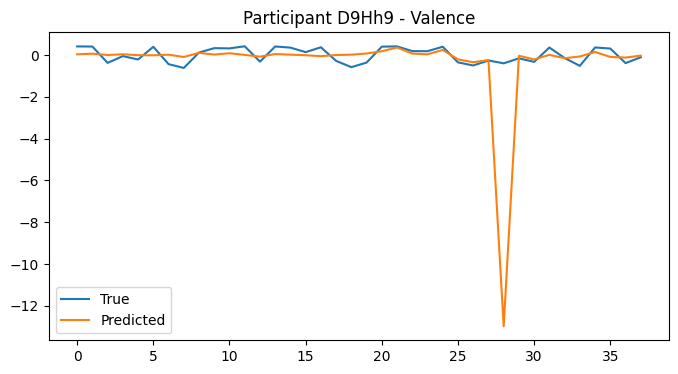

In [ ]:
import matplotlib.pyplot as plt

bad_pid = 'D9Hh9'
mask = np.array(all_test_participants) == bad_pid
plt.figure(figsize=(8, 4))
plt.plot(np.array(all_true_values)[mask], label='True')
plt.plot(np.array(all_fusion_preds)[mask], label='Predicted')
plt.title(f'Participant {bad_pid} - Valence')
plt.legend()
plt.show()


#### **Ridge regression**

---



In [ ]:
# Try Ridge
results_ridge, metrics_ridge = run_evaluation_pipeline(df, gt_full_set, Ridge, {'alpha': 1.0})


 VALENCE Running with Fusion Model: Ridge

=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.3112
Global R²: -0.5958
Global corr: 0.2093, p = 5.2765e-15

Average Fusion Weights across Participants:
FER_weight      0.6647
Pupil_weight    0.3485
GSR_weight      0.4003
dtype: float64

=== Valence Model Per-Participant Fusion Metrics ===
     NRMSE       R2    corr       p participant
0   0.2557   0.4486  0.7414  0.0000       F5tXL
1   0.2933   0.2741  0.6537  0.0000        Gax8
2   0.2620   0.4211  0.6739  0.0000       Hx7dO
3   0.2988   0.2470  0.6254  0.0000       wohkw
4   0.3962  -0.3244  0.5480  0.0004       PPjCX
5   0.3326   0.0669  0.6368  0.0000       tMGNS
6   0.2554   0.4495  0.7263  0.0000       5KB3V
7   0.4287  -0.5505  0.4318  0.0068      EJOiBs
8   0.3024   0.2284  0.5161  0.0009        gf5X
9   0.3089   0.1952  0.5931  0.0001       gjGzb
10  0.3149   0.1636  0.4631  0.0034       LR96S
11  0.2899   0.2908  0.6191  0.0000       CoQmx
12  0.3179   0.1473  0.4133 

#### **RandomForestRegressor**

---



In [ ]:
# Try Random Forest
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, RandomForestRegressor, {'n_estimators': 100, 'random_state': 42})


 VALENCE Running with Fusion Model: RandomForestRegressor

=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.2226
Global R²: 0.1834
Global corr: 0.4677, p = 2.7844e-75

=== Valence Model Per-Participant Fusion Metrics ===
     NRMSE      R2    corr       p participant
0   0.2908  0.2865  0.5382  0.0005       F5tXL
1   0.2954  0.2641  0.6053  0.0001        Gax8
2   0.2507  0.4700  0.7020  0.0000       Hx7dO
3   0.2765  0.3550  0.6478  0.0000       wohkw
4   0.3990 -0.3433  0.5394  0.0005       PPjCX
5   0.5165 -1.2504  0.2250  0.1744       tMGNS
6   0.2665  0.4009  0.6612  0.0000       5KB3V
7   0.5198 -1.2795  0.3801  0.0186      EJOiBs
8   0.3487 -0.0260  0.3476  0.0325        gf5X
9   0.3293  0.0849  0.3612  0.0259       gjGzb
10  0.2833  0.3227  0.5953  0.0001       LR96S
11  0.3562 -0.0703  0.4593  0.0037       CoQmx
12  0.3630 -0.1117  0.2743  0.0956      G5XzoP
13  0.3135  0.1706  0.4148  0.0096      XhsN0o
14  0.7073 -3.2202  0.4801  0.0023       9FGka
15  0.2893  0.

#### **Gradient Boosting Regressor**

---



In [ ]:
# Try Gradient Boosting Regressor
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, GradientBoostingRegressor, {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth':3, 'random_state': 42})


 VALENCE Running with Fusion Model: GradientBoostingRegressor

=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.2197
Global R²: 0.2045
Global corr: 0.4812, p = 3.2475e-80

=== Valence Model Per-Participant Fusion Metrics ===
     NRMSE      R2    corr       p participant
0   0.2598  0.4304  0.6679  0.0000       F5tXL
1   0.2851  0.3141  0.6346  0.0000        Gax8
2   0.2371  0.5259  0.7431  0.0000       Hx7dO
3   0.3001  0.2402  0.5925  0.0001       wohkw
4   0.3794 -0.2146  0.5460  0.0004       PPjCX
5   0.4008 -0.3549  0.5368  0.0005       tMGNS
6   0.2378  0.5230  0.7589  0.0000       5KB3V
7   0.6076 -2.1148  0.3012  0.0661      EJOiBs
8   0.3323  0.0682  0.3683  0.0229        gf5X
9   0.3327  0.0661  0.3397  0.0369       gjGzb
10  0.2889  0.2958  0.6105  0.0000       LR96S
11  0.3537 -0.0555  0.4384  0.0059       CoQmx
12  0.3250  0.1090  0.4658  0.0032      G5XzoP
13  0.3268  0.0990  0.3198  0.0503      XhsN0o
14  0.8159 -4.6154  0.4455  0.0051       9FGka
15  0.2713

#### **SVR Support Vector Regression**

---



In [ ]:
# Try SVR
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, SVR, {'kernel':'rbf', 'C':1.0, 'epsilon':0.1})


 VALENCE Running with Fusion Model: SVR

=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.2155
Global R²: 0.2348
Global corr: 0.5039, p = 5.3548e-89

=== Valence Model Per-Participant Fusion Metrics ===
     NRMSE      R2    corr       p participant
0   0.2519  0.4648  0.6882  0.0000       F5tXL
1   0.2813  0.3322  0.6258  0.0000        Gax8
2   0.2370  0.5262  0.7362  0.0000       Hx7dO
3   0.2842  0.3186  0.6090  0.0000       wohkw
4   0.3625 -0.1087  0.5918  0.0001       PPjCX
5   0.4255 -0.5277  0.5339  0.0006       tMGNS
6   0.2490  0.4769  0.6960  0.0000       5KB3V
7   0.5181 -1.2644  0.3623  0.0254      EJOiBs
8   0.3216  0.1276  0.4471  0.0049        gf5X
9   0.2825  0.3266  0.6060  0.0001       gjGzb
10  0.2939  0.2711  0.5330  0.0006       LR96S
11  0.3248  0.1102  0.5177  0.0009       CoQmx
12  0.3012  0.2347  0.5244  0.0007      G5XzoP
13  0.3107  0.1855  0.4381  0.0059      XhsN0o
14  0.9116 -6.0114  0.5442  0.0004       9FGka
15  0.2771  0.3521  0.6182  0.00